In [1]:
#Import all needed libraries
from googleapiclient.discovery import build
from tqdm import tqdm
import json
import pandas as pd
import numpy as np
import seaborn as sns
import re
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

/Users/hemanta/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
#read the downloaded JSON dataset
with open("prakash_saput_comments.json", "r", encoding="utf-8") as f:
    comment_data = json.load(f)

# Now comment_data is a dictionary
print(f"Loaded {len(comment_data)} videos with comments.")

# Print first three comments of the first video
for video_id, comments in comment_data.items():
    print(f"Video ID: {video_id}")
    print("First 3 comments:", comments[:3])
    break 

Loaded 79 videos with comments.
Video ID: EL7OF3Kqw-4
First 3 comments: [{'author': '@PrakashSaput', 'comment': 'चलचित्र बसन्तमा रहेको एउटा गीत "मोटर" को लिरिकल भिडियो सार्वजनिक गरेका छौँ, चलचित्र बसन्त यहाँहरुको नजिकको हलहरुमा लागिरहेको छ, हेरेर कस्तो लाग्यो प्रतिक्रिया दिन नभुल्नुहोला।'}, {'author': '@bimalagiri1695', 'comment': 'Nice ❤💓💐'}, {'author': '@Pareshrai_official', 'comment': 'Music compose मा Jhuma limbu jiu koi name raixa , यो भाका चै पहिले देखि नै सुनि आएकोले , (सङ्कलन) राख्नु भए देखि अझ राम्रो हुनेथियो कि'}]


We can see that the comments contains Nepali, Romanized Nepali, and English language with some emoji as well.

In [6]:
# We can flatten JSON to build a pandas dataframe 
rows = []
for video_id, comment_list in comment_data.items():
    for comment in comment_list:
        # Make sure it's a dict with 'author' and 'comment'
        if isinstance(comment, dict) and 'author' in comment and 'comment' in comment:
            rows.append({
                "video_id": video_id,
                "author": comment["author"],
                "comment": comment["comment"]
            })
# Create dataFrame
df = pd.DataFrame(rows)
#save the dataframe in csv file
df.to_csv("comments.csv", index = False, escapechar='\\')

In [7]:
#Lets check top of the dataframe
df.head()

,video_id,author,comment
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक..."
1,EL7OF3Kqw-4,@bimalagiri1695,Nice ❤💓💐
2,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...
3,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...
4,EL7OF3Kqw-4,@KRISHFF-j2e,jay Prakash saput


Lets use simple TextBolb (pretrained model) to analyzed the sentiment

In [29]:
from textblob import TextBlob
text = TextBlob("Songs are really nice heart touching plz we need other songs as well plzzz as soon as possible 🙏🙏")
print(text.sentiment)

Sentiment(polarity=0.24375000000000002, subjectivity=0.71875)


In [30]:
comment = 'Music compose मा Jhuma limbu jiu koi name raixa , यो भाका चै पहिले देखि नै सुनि आएकोले , (सङ्कलन) राख्नु भए देखि अझ राम्रो हुनेथियो कि'
text = TextBlob(comment)
print(text.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [31]:
comment = 'Dherai ramro song chha ❤❤'
text = TextBlob(comment)
print(text.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


TextBlob is not able to cpature roman/non english sentiment. It can only do sentiment on pure english comments. I will use multilingual BERT to analyze sentiments, as it is trained on many languages including Nepali.

In [16]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
results = sentiment_pipeline(["मलाई यो गीत धेरै राम्रो लाग्यो।", "I hated this movie."])
print(results)

2025-05-03 15:56:58.027445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Device set to use cpu


[{'label': '5 stars', 'score': 0.5550222396850586}, {'label': '1 star', 'score': 0.7954590916633606}]


In [33]:
comment = "Dherai ramro cha"
sentiment_pipeline(comment)

[{'label': '1 star', 'score': 0.2709515392780304}]

In [8]:
#Filter the comments based on english, nepali and romanized nepali
def detect_script(text):
    try:
        if re.search('[\u0900-\u097F]', text):
            return 'Nepali'
        elif detect(text) == 'en':
            return 'English'
        else:
            return 'Romanized Nepali'
    except LangDetectException:
        return 'Unknown'

In [10]:
# Apply the detect_script function to detect langauge type and visualize the distribution of comments based on language
df['language'] = df['comment'].astype(str).apply(detect_script)

# View distribution
language_counts = df['language'].value_counts()

# Optional: visualize
import matplotlib.pyplot as plt
language_counts.plot(kind='bar', color='skyblue')
plt.title('Language Distribution of Comments')
plt.ylabel('Number of Comments')
plt.xlabel('Language')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


KeyboardInterrupt



In [11]:
#visualize unknown comments 
# Filter and view unknown language rows
unknown_comments = df[df['language'] == 'Unknown']
# Show the first few unknown comments
print(unknown_comments[['comment']].head(10))

                                             comment
16  https://youtu.be/CTbuTIWvOaE?si=qLr3aNKsc83FL77G
22  https://youtu.be/qGb6SxwsZNs?si=4jTJHj-vmuU2U8ui
32                                      Wow ❤❤❤❤❤❤❤❤
36                                                ❤❤
37                                         ❤❤❤❤❤❤❤❤❤
52                                             ❤❤❤❤❤
54                                              ❤❤❤❤
60                                                🎉🎉
68                                             🎉🎉🎉🎉🎉
69                                            ❤❤❤❤❤❤


In [12]:
#save data with type of langauage in a new csv file
df.to_csv("data_with_comment_dustributions.csv", index = False, escapechar='\\')

In [13]:
#for further analysis keep only comments classified as Nepali or English
df_cleaned = df[df['language'].isin(['Nepali', 'English'])]

#Lets preview the filtered data
print(df_cleaned.head())
df_cleaned.to_csv("data_with_english_nepali_comments.csv", index = False, escapechar='\\')

       video_id                           author  \
0   EL7OF3Kqw-4                    @PrakashSaput   
2   EL7OF3Kqw-4              @Pareshrai_official   
3   EL7OF3Kqw-4  @SunilsenchuryAakarengineer-y3w   
9   EL7OF3Kqw-4                @SushmitaKC-nz5ch   
12  EL7OF3Kqw-4                    @Silent-Simma   

                                              comment language  
0   चलचित्र बसन्तमा रहेको एउटा गीत "मोटर" को लिरिक...   Nepali  
2   Music compose मा Jhuma limbu jiu koi name raix...   Nepali  
3   Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...  English  
9   Songs are really nice heart touching plz we ne...  English  
12          Wordings are great in the song. Love it🙏🏻  English  


In [14]:
#Lets check size of the data with Nepali/English comments
df_cleaned.shape

(120144, 4)

In [18]:
MAX_LEN = 512

# Truncate text to 512 characters (approx. safe range for most BERT models)
df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)

# Apply sentiment analysis to truncated comments
df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(
    lambda x: sentiment_pipeline(x)[0]['label']
)

/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/2016998412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/2016998412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(


In [19]:
df_cleaned.head()

,video_id,author,comment,language,short_comment,sentiment
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",Nepali,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",3 stars
2,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...,Nepali,Music compose मा Jhuma limbu jiu koi name raix...,3 stars
3,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,English,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,5 stars
9,EL7OF3Kqw-4,@SushmitaKC-nz5ch,Songs are really nice heart touching plz we ne...,English,Songs are really nice heart touching plz we ne...,5 stars
12,EL7OF3Kqw-4,@Silent-Simma,Wordings are great in the song. Love it🙏🏻,English,Wordings are great in the song. Love it🙏🏻,5 stars


In [ ]:
#Truncate long comments as BERTs input token size is 512 so truncate each comment to 512 characters
# df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)

In [ ]:
# Apply sentiment analysis on the truncated comments
df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_28868/4011847990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['short_comment'] = df_cleaned['comment'].astype(str).str.slice(0, 512)
/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_28868/4011847990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment'] = df_cleaned['short_comment'].apply(lambda x: sentiment_pipeline(x)[0]['label'])


In [20]:
#Save the data with short comments in a csv file
df_cleaned.to_csv("data_with_short_comments_for_further_analysis.csv", index = False, escapechar='\\')

In [31]:
df_final = pd.read_csv("data_with_short_comments_for_further_analysis.csv", engine='python', escapechar='\\', on_bad_lines='skip')

In [34]:
df_final.head()

,video_id,author,comment,language,short_comment,sentiment
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",Nepali,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",3 stars
1,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...,Nepali,Music compose मा Jhuma limbu jiu koi name raix...,3 stars
2,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,English,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,5 stars
3,EL7OF3Kqw-4,@SushmitaKC-nz5ch,Songs are really nice heart touching plz we ne...,English,Songs are really nice heart touching plz we ne...,5 stars
4,EL7OF3Kqw-4,@Silent-Simma,Wordings are great in the song. Love it🙏🏻,English,Wordings are great in the song. Love it🙏🏻,5 stars


In [36]:
#convert to numerical scale
# Extract numeric rating (1–5)
extracted = df_final['sentiment'].str.extract(r'(\d)')
df_cleaned['sentiment_score'] = extracted.dropna().astype(int)


/var/folders/3v/sckjdc_973x861_x7g36ws0c0000gn/T/ipykernel_5014/1139638961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment_score'] = extracted.dropna().astype(int)


<Axes: title={'center': 'Sentiment Score Distribution'}, xlabel='sentiment_score'>

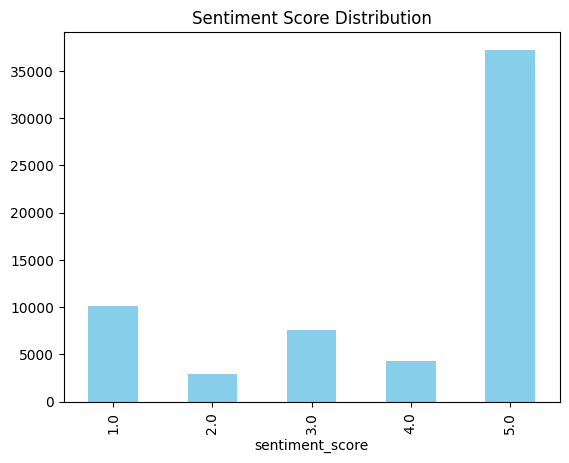

In [37]:
#Count sentiment score and plot it
df_cleaned['sentiment_score'].value_counts().sort_index().plot(kind='bar', color='skyblue', title='Sentiment Score Distribution')

In [38]:
#Set the filter only positive or negative
positive = df_cleaned[df_cleaned['sentiment_score'] >= 4]
negative = df_cleaned[df_cleaned['sentiment_score'] <= 2]

Still some of the comments that contains romanized nepali are passed through the model. We will handel them later 

In [39]:
df_cleaned.head()

,video_id,author,comment,language,short_comment,sentiment,sentiment_score
0,EL7OF3Kqw-4,@PrakashSaput,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",Nepali,"चलचित्र बसन्तमा रहेको एउटा गीत ""मोटर"" को लिरिक...",3 stars,3.0
2,EL7OF3Kqw-4,@Pareshrai_official,Music compose मा Jhuma limbu jiu koi name raix...,Nepali,Music compose मा Jhuma limbu jiu koi name raix...,3 stars,5.0
3,EL7OF3Kqw-4,@SunilsenchuryAakarengineer-y3w,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,English,Prakash dai is My best hearing in Nepal❤❤ ❤❤❤❤...,5 stars,5.0
9,EL7OF3Kqw-4,@SushmitaKC-nz5ch,Songs are really nice heart touching plz we ne...,English,Songs are really nice heart touching plz we ne...,5 stars,1.0
12,EL7OF3Kqw-4,@Silent-Simma,Wordings are great in the song. Love it🙏🏻,English,Wordings are great in the song. Love it🙏🏻,5 stars,4.0


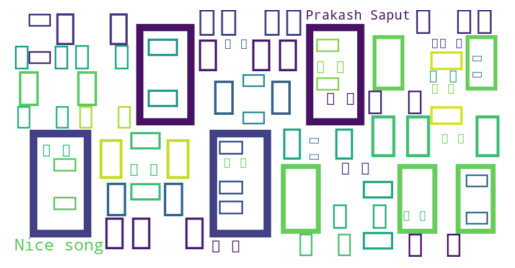

In [51]:
#Visualize top words in the comments with sentiment score high
from wordcloud import WordCloud
text_pos = " ".join(df_cleaned[df_cleaned['sentiment_score'] >= 4]['comment'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='viridis').generate(text_pos)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

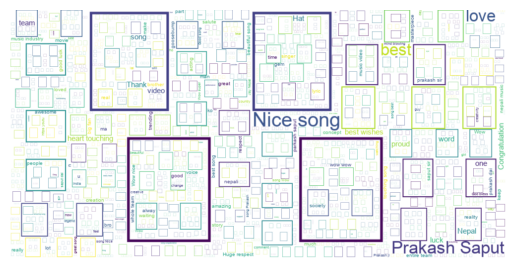

In [59]:
wordcloud = WordCloud(
    font_path = '/System/Library/Fonts/Supplemental/Arial.ttf',
    width=1000,
    height=500,
    background_color='white',
    max_words=1000
).generate(text_pos)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()